# *ANN - Classification for Higgs Signal vs. Background*

ELEFTHERIOS MARIOS ZOGRAFOS\
AEM : 4428

### *1. Importing Libraries*

In [34]:
import os
# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### _2. The ANN Implementation_

1. **Loading the Data**

   - First, load the data into a DataFrame.
   
     > **_Note:_** The dataset contains instances of `e+00.1`, which Python does not recognize as numeric values by default. To prevent errors, these values must be modified as shown below.


In [35]:
def load_and_preprocess(filepath: str) -> tuple:
    """
    Load CSV, fix malformed scientific notation, split into features and label
    """
    df = pd.read_csv(filepath, header=None) \
           .replace(to_replace=r'[eE]\+?\d+\.\d+', value=0, regex=True) \
           .astype(np.float32)
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    return X, y


 2. **Train/Test Split and Scaling**


In [36]:

def split_and_scale(X: np.ndarray,
                    y: np.ndarray,
                    test_size: float = 0.25,
                    random_state: int = 32) -> tuple:
    """
    Stratified train/test split, then apply Z-score standardization.
    """

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test


 3. **Network Architecture**


- **Input layer**  
  - Dimension = number of features (28 for Complete, 21 for Low-level, 7 for High-level)

- **Hidden layers**  
  1. `Dense(256)` → ELU activation → BatchNormalization → Dropout(0.3)  
  2. `Dense(128)` → ELU activation → BatchNormalization → Dropout(0.3)  
  3. `Dense(64)`  → ELU activation → BatchNormalization → Dropout(0.3)  
  4. `Dense(32)`  → ELU activation → BatchNormalization → Dropout(0.2)  
  5. `Dense(16)`  → ELU activation → BatchNormalization → Dropout(0.2)

- **Output layer**  
  - `Dense(1)` with Sigmoid activation

- **Loss function**  
  - Binary cross-entropy

- **Optimizer**  
  - Adam with learning rate = 1e-3

- **Metrics**  
  - Binary accuracy  
  - AUC

- **Regularization**  
  - Dropout after each hidden layer to prevent overfitting  
  - Batch Normalization for faster, more stable training

In [37]:

def build_ann(input_dim: int) -> models.Model:
    """
    Build a 5-layer MLP with ELU activations, BatchNormalization, and dropout
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='elu'), layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(128, activation='elu'), layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(64, activation='elu'),  layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(32, activation='elu'),  layers.BatchNormalization(), layers.Dropout(0.2),
        layers.Dense(16, activation='elu'),  layers.BatchNormalization(), layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

4. **Plotting Functions**

In [38]:

def plot_confusion(y_true: np.ndarray,
                   y_pred: np.ndarray,
                   title: str):
    """
    Plot confusion matrix at threshold 0.5.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix - {title}')
    fig.tight_layout()
    plt.show()


def plot_roc(y_true: np.ndarray,
             y_prob: np.ndarray,
             title: str) -> dict:
    """
    Plot ROC curve and compute AUC and accuracy at 0.5 threshold.

    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot([0,1], [0,1], '--', color='gray')
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_true, y_prob):.3f}')
    ax.set_title(f'ROC Curve - {title}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    fig.tight_layout()
    plt.show()
    return {
        'accuracy': accuracy_score(y_true, (y_prob > 0.5).astype(int)),
        'auc': roc_auc_score(y_true, y_prob)
    }


5. **Main Analysis Pipeline**


**Training Strategy**  
  - EarlyStopping monitored on validation AUC (patience = 10, restore best weights)  
  - ReduceLROnPlateau on validation AUC (factor = 0.5, patience = 5, min_lr = 1e-6)  
  - Maximum epochs = 500, batch size = 256, `verbose=0` for silent training  

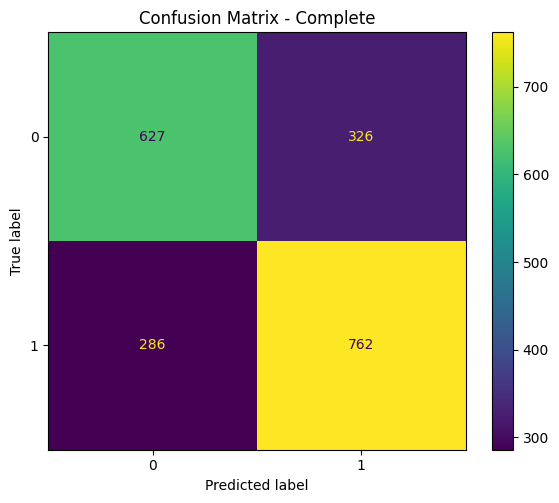

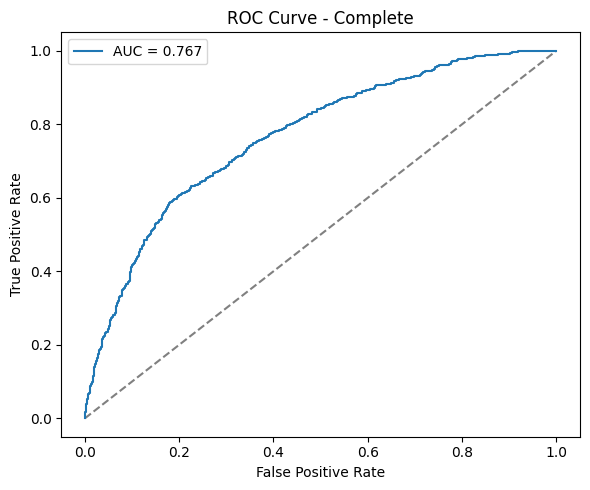

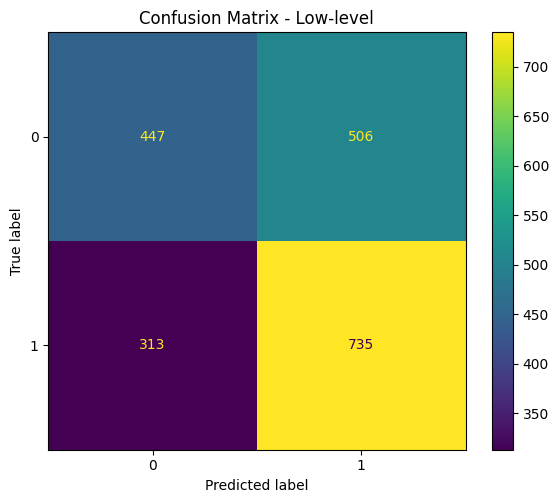

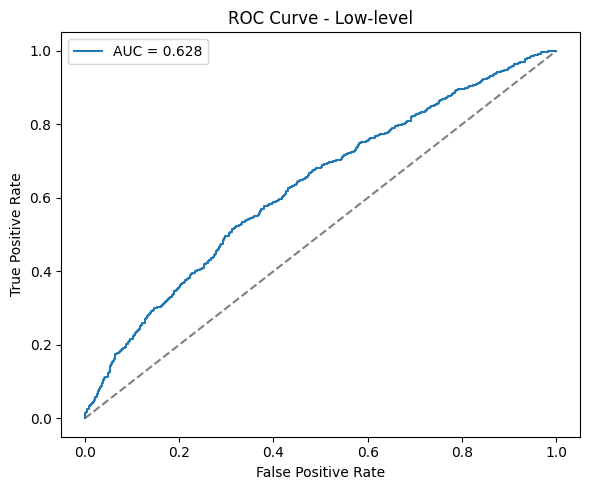

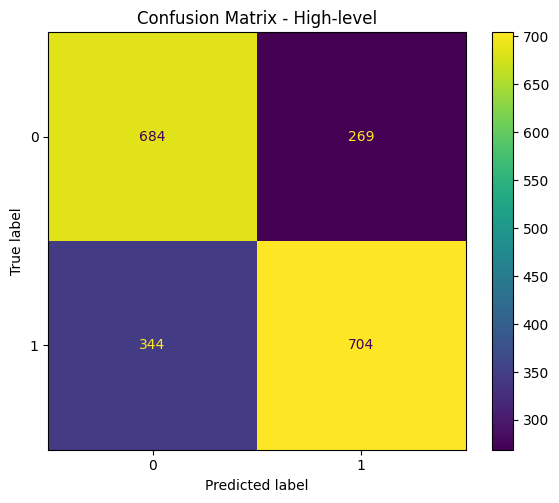

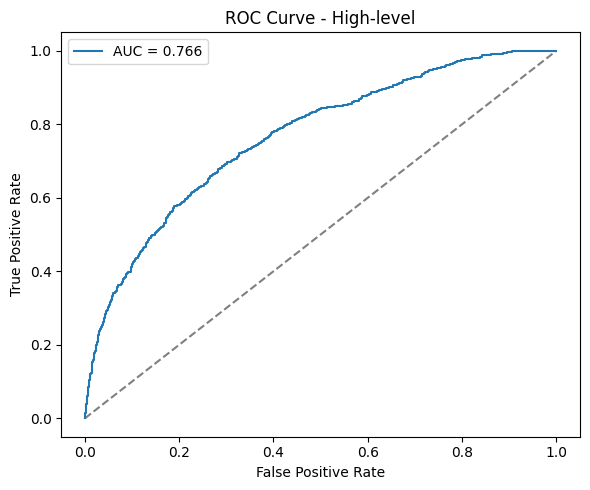

In [39]:
filepath = 'HIGGS_8K.csv'
X_all, y = load_and_preprocess(filepath)
feature_sets = {
    'Complete': X_all,
    'Low-level': X_all.iloc[:, :21],
    'High-level': X_all.iloc[:, 21:]
}
results = {}
for label, X in feature_sets.items():
    # Split & scale
    X_train, X_test, y_train, y_test = split_and_scale(X, y)
    # Build and train model
    model = build_ann(X_train.shape[1])
    es = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
    rp = callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-6)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=256,
        callbacks=[es, rp],
        verbose=0
    )
    # Evaluate
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    # Plot
    plot_confusion(y_test, y_pred, label)
    stats = plot_roc(y_test, y_prob, label)
    results[label] = stats

### Summary

In [40]:
summary_df = pd.DataFrame(results).T
summary_df

,accuracy,auc
Complete,0.694153,0.766846
Low-level,0.590705,0.628352
High-level,0.693653,0.765636
